In [13]:
# PREPROCESSING -- Load and Clean MovieLens Data
import pandas as pd
import numpy as np

# Define file paths
ratings_path = 'C:\\UNI\\AI and ML\\ml-latest-small\\ratings.csv'
movies_path = 'C:\\UNI\\AI and ML\\ml-latest-small\\movies.csv'

# Load datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Display basic info
print("Ratings Info:")
print(ratings.info())
print("\nMovies Info:")
print(movies.info())

# Handle missing values
print("\nMissing values in ratings:\n", ratings.isnull().sum())
print("Missing values in movies:\n", movies.isnull().sum())

# Dropping lines with missing values
ratings.dropna(inplace=True)
movies.dropna(inplace=True)

# Drop duplicates if any
ratings.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)

# Min-Max normalization
min_original_rating = ratings['rating'].min()
max_original_rating = ratings['rating'].max()

# Desired range
new_min = 0
new_max = 5

# Apply the Min-Max scaling formula to the specified new range
# The formula is: X_scaled = (new_max - new_min) * ((X - X_min) / (X_max - X_min)) + new_min
ratings['rating_minmax_0_5'] = (new_max - new_min) * \
                              ((ratings['rating'] - min_original_rating) / \
                               (max_original_rating - min_original_rating)) + new_min

print("\nRatings with Min-Max Scaled column (range 0 to 5):")
print(ratings[['userId', 'movieId', 'rating', 'rating_minmax_0_5']].head())

# Check new min and max values to verify
print(f"\nNew min rating (0-5 scale): {ratings['rating_minmax_0_5'].min()}")
print(f"New max rating (0-5 scale): {ratings['rating_minmax_0_5'].max()}")

ratings.head()


Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64

Ratings with Min-Max Scaled col

,userId,movieId,rating,timestamp,rating_minmax_0_5
0,1,1,4.0,964982703,3.888889
1,1,3,4.0,964981247,3.888889
2,1,6,4.0,964982224,3.888889
3,1,47,5.0,964983815,5.000000
4,1,50,5.0,964982931,5.000000


In [14]:
# Feature Engineering -- Manage Genre, Year, Tags

from sklearn.feature_extraction.text import TfidfVectorizer

# Genre One-Hot Encoding
# Replace '(no genres listed)' with empty string for safety
movies['genres'] = movies['genres'].replace('(no genres listed)', '')

# Create one-hot encoding for genres
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genre_dummies], axis=1)

print("Genres one-hot encoded:")
print(genre_dummies.head())

# Extract Year from Title 
# Use regex to extract year from the movie title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

print("\nExtracted release years:")
print(movies[['title', 'year']].head())

# Tags Processing with TF-IDF
# Load tags dataset
tags_path = 'C:\\UNI\\AI and ML\\ml-latest-small\\tags.csv'
tags = pd.read_csv(tags_path)

# Group tags per movie
tag_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Apply TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=100)  # max_features=100, meaning the top 100 tag terms across all movies will be used
tag_matrix = tfidf.fit_transform(tag_grouped['tag'])

# Convert to DataFrame and merge with movies
tag_df = pd.DataFrame(tag_matrix.toarray(), columns=tfidf.get_feature_names_out())
tag_df['movieId'] = tag_grouped['movieId']
movies = pd.merge(movies, tag_df, on='movieId', how='left').fillna(0)

print("\nTF-IDF tag features added. Example:")
print(movies[tfidf.get_feature_names_out()].head())

# Final structure
print(f"\nMovies with engineered features: {movies.shape}")


Genres one-hot encoded:
   Action  Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  \
0       0          1          1         1       1      0            0      0   
1       0          1          0         1       0      0            0      0   
2       0          0          0         0       1      0            0      0   
3       0          0          0         0       1      0            0      1   
4       0          0          0         0       1      0            0      0   

   Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  \
0        1          0       0     0        0        0        0       0   
1        1          0       0     0        0        0        0       0   
2        0          0       0     0        0        0        1       0   
3        0          0       0     0        0        0        1       0   
4        0          0       0     0        0        0        0       0   

   Thriller  War  Western  
0         0    0      

In [15]:
# Train/Validation Split (Revised for Warm-Start Evaluation)
from sklearn.model_selection import train_test_split
import os

# Merge ratings with enriched movie features
full_df = pd.merge(ratings, movies, on='movieId', how='inner')

# Shuffle for safety
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Directory to save splits
output_dir = 'C:\\UNI\\AI and ML\\Project second try\\processed_fold'
os.makedirs(output_dir, exist_ok=True)

# Apply a simple train_test_split (not GroupKFold) to allow user overlap
# This is for evaluating models on existing users' unseen ratings
df_train, df_val = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['userId'])

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Save to CSV (optional, but good for consistency)
df_train.to_csv(os.path.join(output_dir, f"train_split.csv"), index=False)
df_val.to_csv(os.path.join(output_dir, f"val_split.csv"), index=False)

print(f"[+] Training: {df_train.shape}, Validation: {df_val.shape}")
print(f"[+] Unique users in df_train: {df_train['userId'].nunique()}")
print(f"[+] Unique users in df_val: {df_val['userId'].nunique()}")
print(f"[+] Overlapping users: {len(set(df_train['userId'].unique()).intersection(df_val['userId'].unique()))}")

print("\n [+][+][+] Data splitting complete. Splits saved in:", output_dir)

# Load these new splits into df_train and df_val for the rest of the notebook
# (This is already handled by the subsequent cells that load fold 1, but for safety in case you run cells individually)
# df_train = pd.read_csv(os.path.join(output_dir, f'train_split.csv'))
# df_val = pd.read_csv(os.path.join(output_dir, f'val_split.csv'))

[+] Training: (80668, 127), Validation: (20168, 127)
[+] Unique users in df_train: 610
[+] Unique users in df_val: 610
[+] Overlapping users: 610

 [+][+][+] Data splitting complete. Splits saved in: C:\UNI\AI and ML\Project second try\processed_fold


--- Starting EDA Visualizations ---


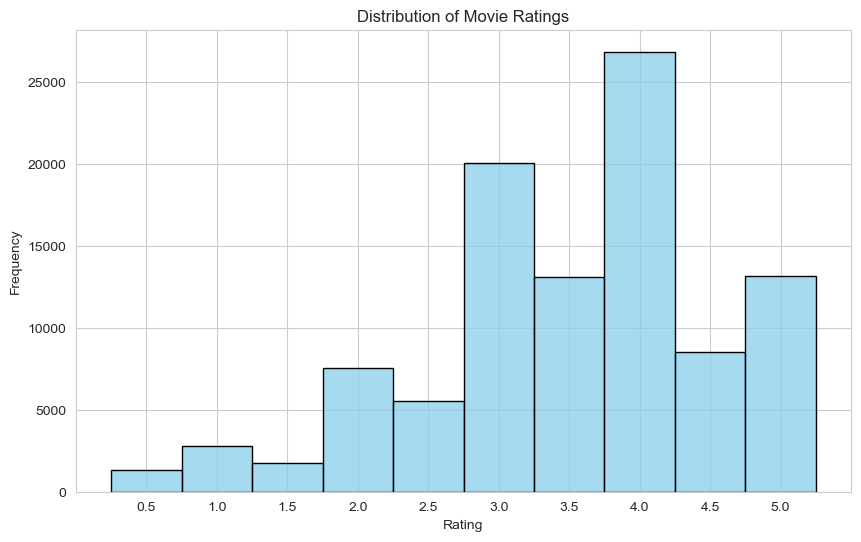

Generated: Distribution of Movie Ratings


C:\Users\Asus\AppData\Local\Temp\ipykernel_23612\2510647014.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


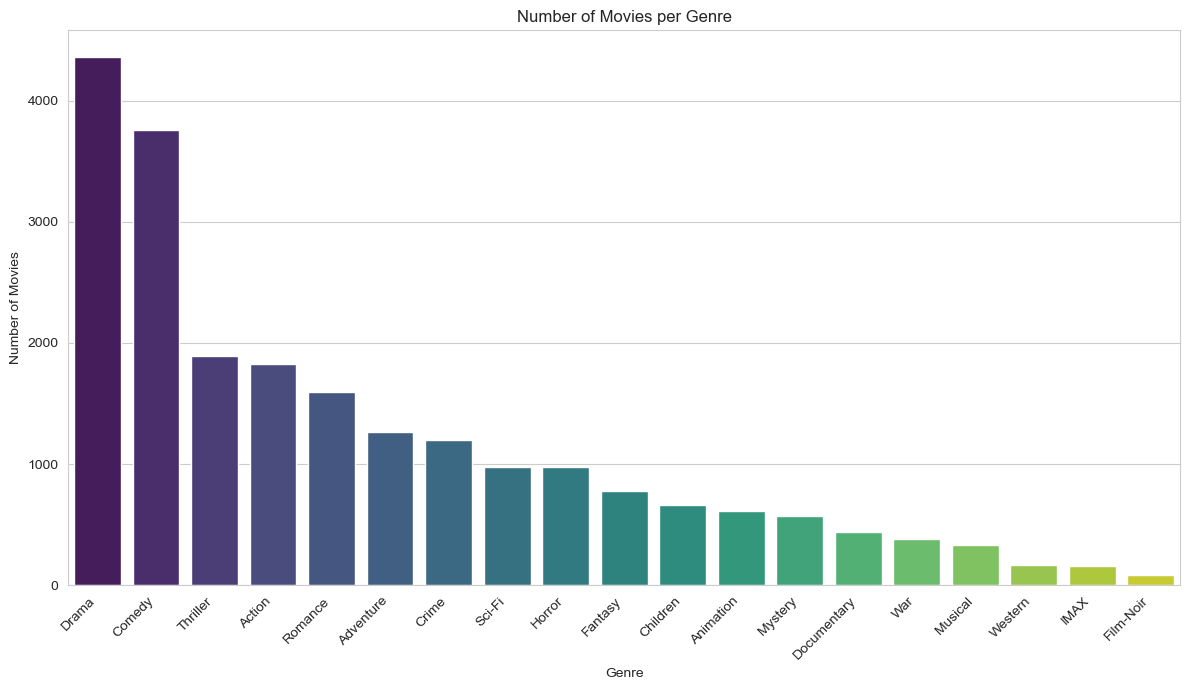

Generated: Number of Movies per Genre


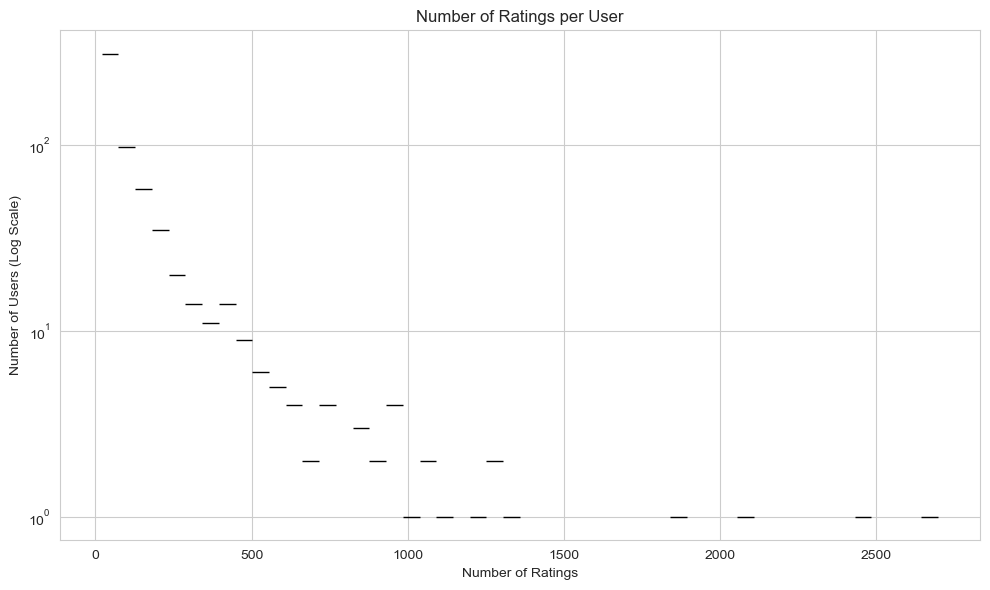

Generated: Number of Ratings per User


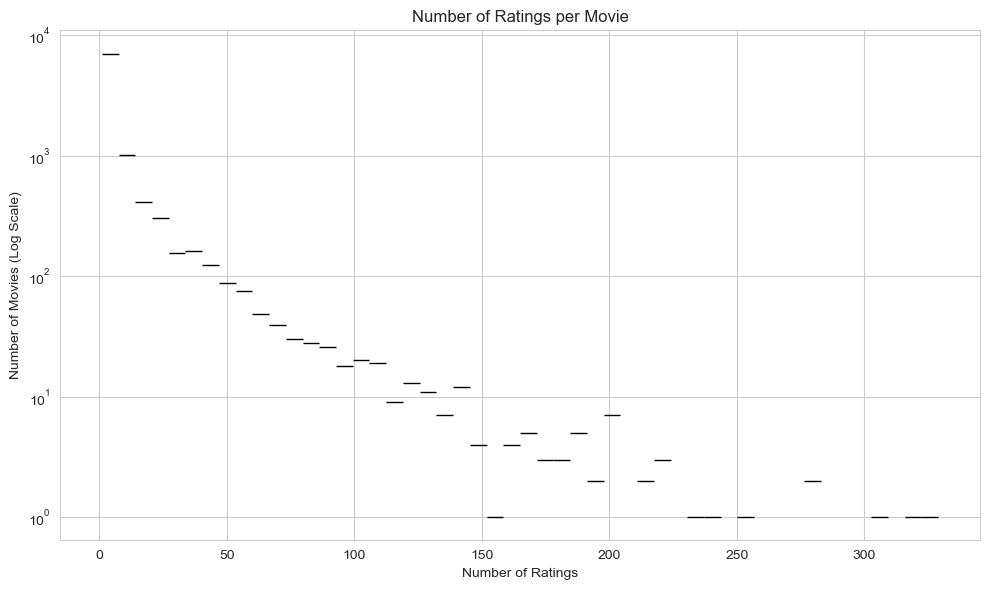

Generated: Number of Ratings per Movie


C:\Users\Asus\AppData\Local\Temp\ipykernel_23612\2510647014.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_rating_per_genre_series.index, y=average_rating_per_genre_series.values, palette='coolwarm')


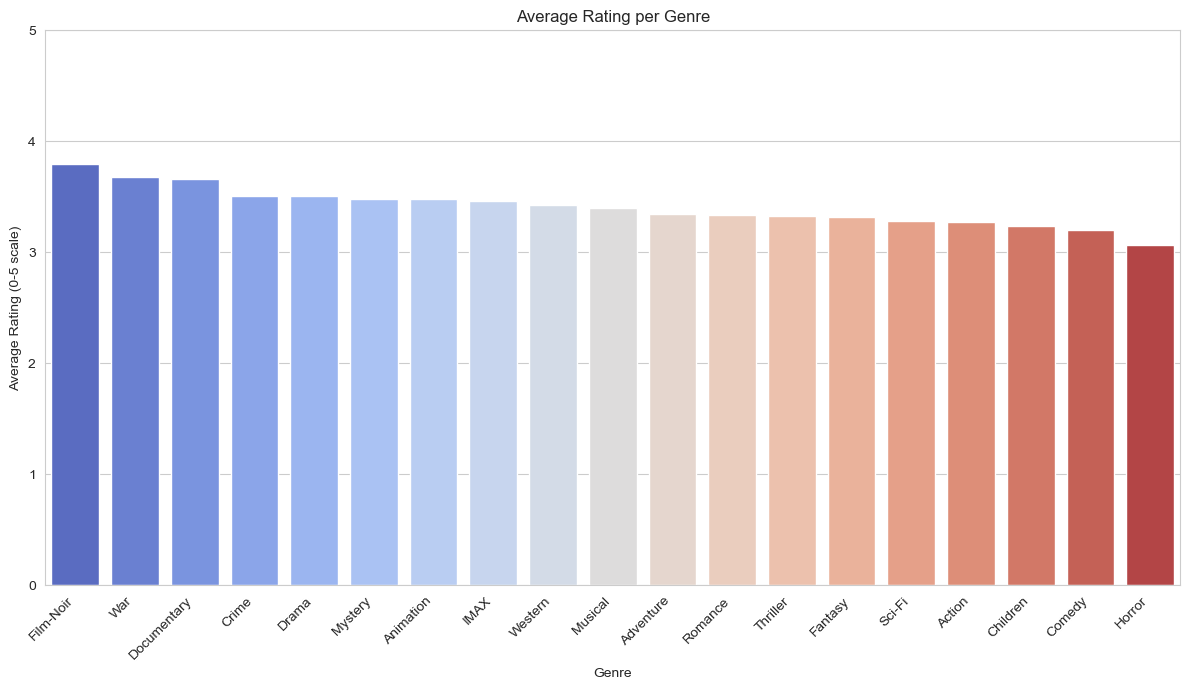

Generated: Average Rating per Genre

--- EDA Visualizations Complete ---


In [16]:
# Exploratory Data Analysis (EDA) Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")

print("--- Starting EDA Visualizations ---")

# 1. Distribution of Movie Ratings (Histogram) 
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=np.arange(0.25, 5.75, 0.5), kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.show()
print("Generated: Distribution of Movie Ratings")

# 2. Number of Movies per Genre (Bar Chart) 
# Re-calculate genre counts from the 'movies' DataFrame (which has genre dummies)
# Exclude 'movieId', 'title', 'genres', 'year', 'year_norm' and TF-IDF tag columns
# from consideration to only count genre columns.
# We need to make sure 'movies' DataFrame is available and has the genre dummy columns.
# Assuming 'genre_dummies' and 'tfidf.get_feature_names_out()' were used before.
# Let's rebuild genre_cols for robust access.
all_genres = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Ensure movies DataFrame has genre columns, created in Cell 2.
genre_counts = movies[all_genres].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Generated: Number of Movies per Genre")

# 3. Number of Ratings per User (Histogram with Log Scale) 
user_rating_counts = ratings.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, color='lightcoral', edgecolor='black', log_scale=(False, True)) # Y-axis log scale
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (Log Scale)')
plt.tight_layout()
plt.show()
print("Generated: Number of Ratings per User")

# 4. Number of Ratings per Movie (Histogram with Log Scale) 
movie_rating_counts = ratings.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, color='lightgreen', edgecolor='black', log_scale=(False, True)) # Y-axis log scale
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies (Log Scale)')
plt.tight_layout()
plt.show()
print("Generated: Number of Ratings per Movie")

# 5. Average Rating per Genre (Bar Chart) 
# To calculate this, merge ratings with movies to get genre info for each rating
ratings_with_genres = pd.merge(ratings, movies[['movieId'] + all_genres], on='movieId', how='left')

# Calculate average rating for each genre
average_rating_per_genre = {}
for genre in all_genres:
    # Get all ratings for movies belonging to this genre
    genre_ratings = ratings_with_genres[ratings_with_genres[genre] == 1]['rating_minmax_0_5']
    if not genre_ratings.empty:
        average_rating_per_genre[genre] = genre_ratings.mean()

average_rating_per_genre_series = pd.Series(average_rating_per_genre).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=average_rating_per_genre_series.index, y=average_rating_per_genre_series.values, palette='coolwarm')
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating (0-5 scale)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 5) # Ensure y-axis is 0-5 for ratings
plt.tight_layout()
plt.show()
print("Generated: Average Rating per Genre")

print("\n--- EDA Visualizations Complete ---")

--- Starting User Clustering Visualization ---


c:\Users\Asus\anaconda3\envs\FilmRaccomandation\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


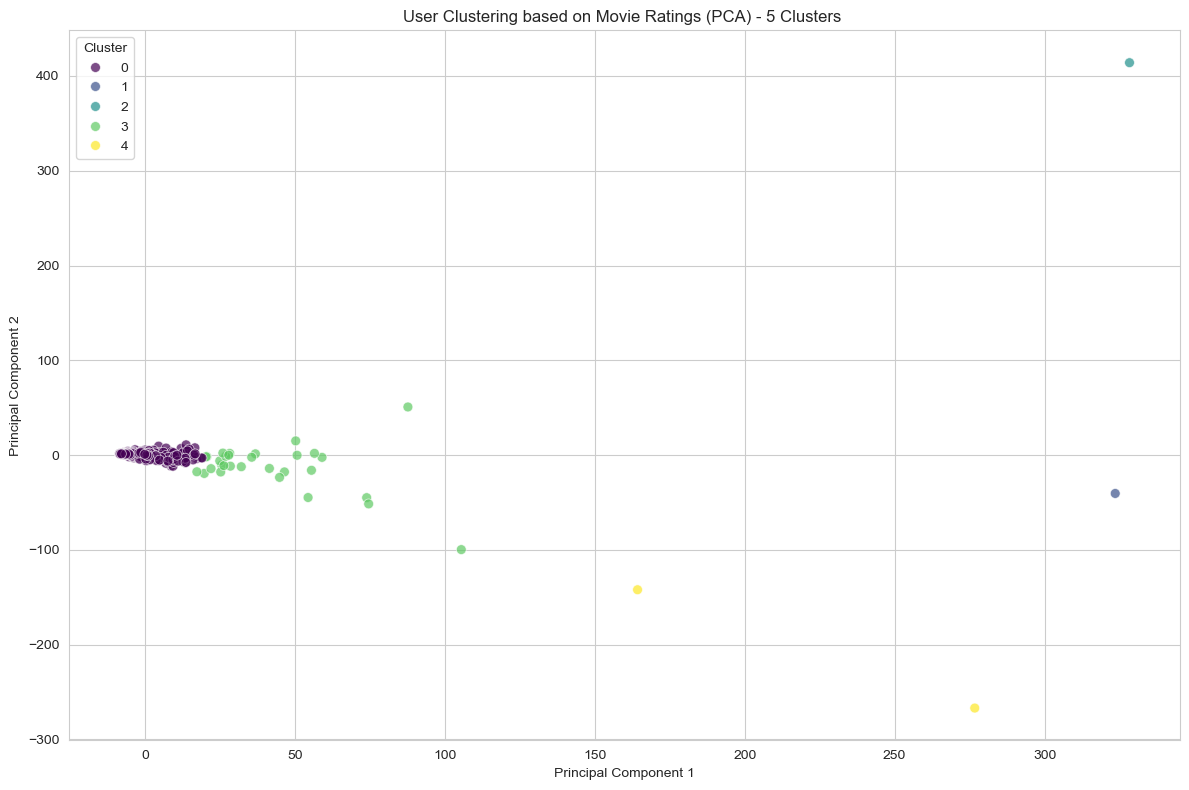

Generated: User Clustering (PCA) with 5 clusters

--- User Clustering Visualizations Complete ---


In [27]:
# User Clustering based on Movie Ratings (PCA/KMeans)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Set a style for better aesthetics
sns.set_style("whitegrid")

print("--- Starting User Clustering Visualization ---")

# 1. Create a User-Item Matrix of actual ratings
# Use the full_df (which contains all ratings before train/val split) for this to get all user-movie interactions
user_item_matrix_full = full_df.pivot_table(index='userId', columns='movieId', values='rating_minmax_0_5')

# Fill NaN values with a neutral value (e.g., 0). This is important for PCA.
user_item_matrix_full_filled = user_item_matrix_full.fillna(0)

# 2. Apply PCA to reduce user rating dimensions to 2
# Scale the data before PCA is often good practice if ranges vary, though 0-5 is somewhat consistent.
scaler_user = StandardScaler()
user_matrix_scaled = scaler_user.fit_transform(user_item_matrix_full_filled)

pca_user = PCA(n_components=2, random_state=42)
components_user = pca_user.fit_transform(user_matrix_scaled)

# Create a DataFrame for plotting
user_pca_df = pd.DataFrame(data=components_user, columns=['Principal Component 1', 'Principal Component 2'])
user_pca_df['userId'] = user_item_matrix_full_filled.index

# 3. Apply K-Means Clustering to the 2D PCA components
# We'll use 5 clusters as suggested by your proposal's image example.
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for robust initialization
user_pca_df['Cluster'] = kmeans.fit_predict(components_user)

# 4. Plotting User Clustering (Scatter Plot)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', 
                data=user_pca_df, palette='viridis', alpha=0.7, s=50) # Use 'viridis' or 'tab10'
plt.title(f'User Clustering based on Movie Ratings (PCA) - {n_clusters} Clusters ')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Generated: User Clustering (PCA) with {n_clusters} clusters")

print("\n--- User Clustering Visualizations Complete ---")

--- Starting User-Item Interaction Sparsity Heatmap ---


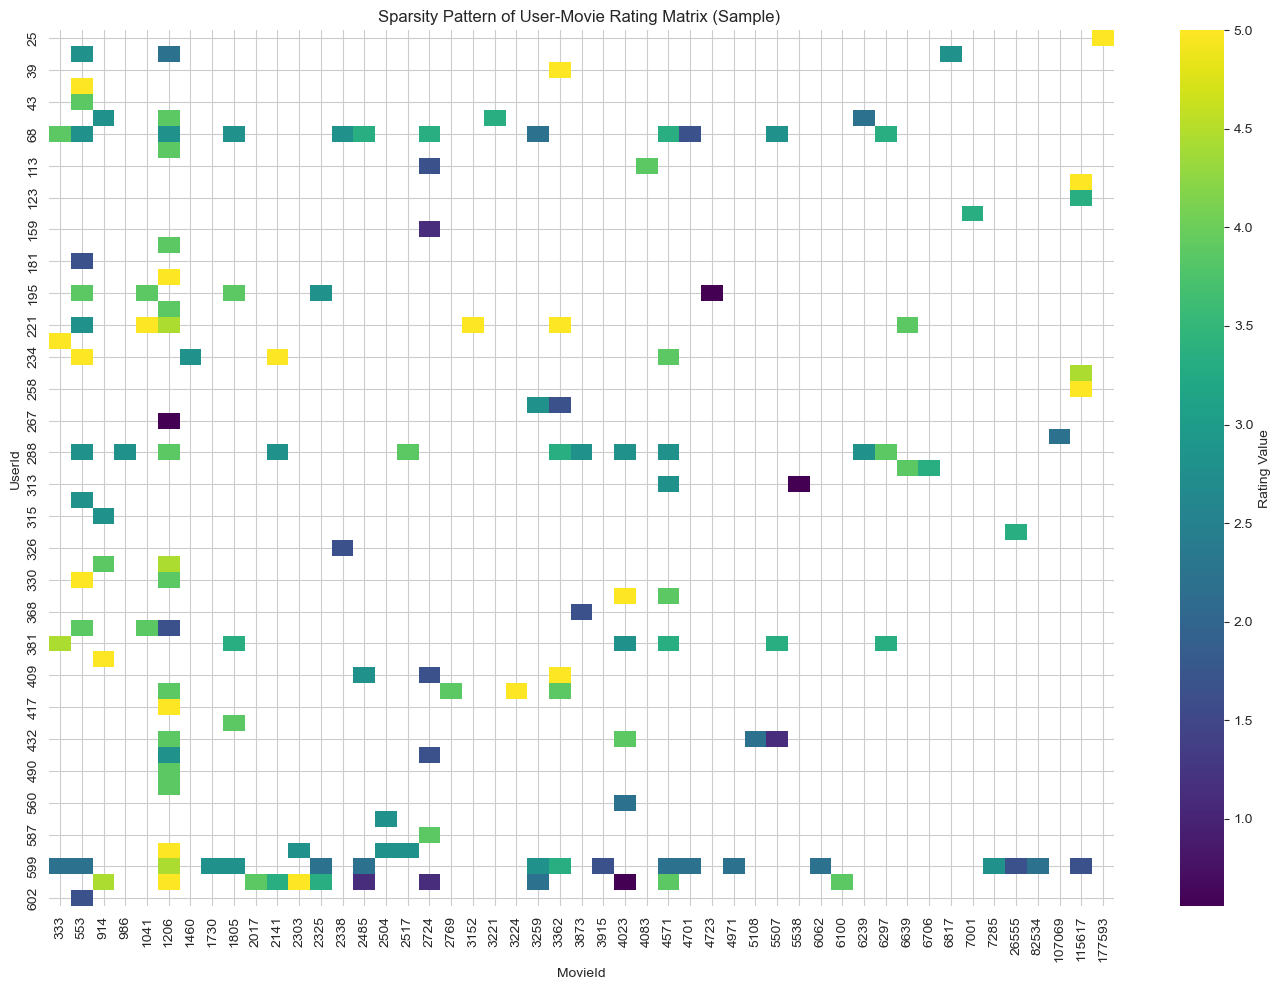

Generated: User-Item Interaction Sparsity Heatmap

--- User-Item Interaction Sparsity Heatmap Complete ---


In [28]:
# User-Item Interaction Sparsity Heatmap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- Starting User-Item Interaction Sparsity Heatmap ---")

# Create a User-Movie matrix (can be the same as user_item_matrix_full from clustering)
# It's better to use a subset for visualization to keep it readable.
# Let's use a sample of 100 users and 100 movies.
sample_users = ratings['userId'].unique()
if len(sample_users) > 100:
    sample_users = np.random.choice(sample_users, size=100, replace=False)

sample_movies = ratings['movieId'].unique()
if len(sample_movies) > 100:
    sample_movies = np.random.choice(sample_movies, size=100, replace=False)

# Filter the full_df (all ratings) for the sample users and movies
sample_ratings_df = full_df[(full_df['userId'].isin(sample_users)) & (full_df['movieId'].isin(sample_movies))]

# Pivot to create the sparse matrix for the sample
sample_user_item_matrix = sample_ratings_df.pivot_table(index='userId', columns='movieId', values='rating_minmax_0_5')

plt.figure(figsize=(14, 10))
# Use a heatmap to visualize the sparsity
# cmap='viridis' or 'plasma' are good. cbar_kws for color bar label.
sns.heatmap(sample_user_item_matrix, cmap='viridis', cbar_kws={'label': 'Rating Value'})
plt.title('Sparsity Pattern of User-Movie Rating Matrix (Sample) ')
plt.xlabel('MovieId')
plt.ylabel('UserId')
plt.tight_layout()
plt.show()
print("Generated: User-Item Interaction Sparsity Heatmap")

print("\n--- User-Item Interaction Sparsity Heatmap Complete ---")

In [ ]:
# Random Recommender Baseline

import numpy as np
import pandas as pd
import os

# --- 🔧 Recommendation and Evaluation Utilities ---

def get_top_n_recommendations(pred_matrix_raw, df_train_current_split, df_val_current_split, n=5, cold_start_strategy='popular_movies'):
    """
    Recommend top-N items for each user in df_val_current_split.
    Handles cold-start users (not in pred_matrix_raw's index) and movies.
    """
    top_n = {}
    
    # Calculate popular movies for cold-start fallback (based on current df_train_current_split)
    movie_popularity = df_train_current_split['movieId'].value_counts()
    most_popular_movies_overall = movie_popularity.index.tolist()
    
    # Get all unique movie IDs present in our overall movie_features (which is comprehensive)
    all_known_movie_ids = movies['movieId'].unique() 
    
    # Pre-process pred_matrix_raw to handle missing columns (movies not seen in training)
    pred_matrix_full_movies = pred_matrix_raw.reindex(columns=all_known_movie_ids, fill_value=np.nan)

    # Removed debug print sampling users for model debug
    
    # Iterate over users in the VALIDATION set
    for user_id in df_val_current_split['userId'].unique():
        user_recs = []
        
        user_train_data = df_train_current_split[df_train_current_split.userId == user_id]
        seen_movies = set(user_train_data['movieId'])
        
        # --- Try to get recommendations from the model's output (pred_matrix_raw) ---
        if user_id in pred_matrix_full_movies.index: # User has predictions from the trained model
            user_predictions_series = pred_matrix_full_movies.loc[user_id].copy()
            
            # Filter out seen movies
            unseen_scores = user_predictions_series[~user_predictions_series.index.isin(seen_movies)]
            unseen_scores = unseen_scores.dropna() # Drop any NaNs (e.g., from reindexing)

            # Removed debug prints for unseen_scores and relevant_unseen_scores
            
            # Only consider scores that are strictly positive for recommendations
            relevant_unseen_scores = unseen_scores[unseen_scores > 0.0] 
            
            if not relevant_unseen_scores.empty:
                user_recs = relevant_unseen_scores.sort_values(ascending=False).head(n).index.tolist()
            
        # --- Cold-start/Fallback if no recommendations found from the model directly ---
        if not user_recs: 
            if cold_start_strategy == 'popular_movies':
                candidate_movies = [
                    m for m in most_popular_movies_overall 
                    if m not in seen_movies and m in all_known_movie_ids
                ]
                user_recs = candidate_movies[:n]
            
            # Final fallback: if even popular movies don't yield enough, pick random from remaining unseen.
            if len(user_recs) < n:
                current_recs_set = set(user_recs)
                all_remaining_unseen_candidates = list(set(all_known_movie_ids) - seen_movies - current_recs_set)
                if all_remaining_unseen_candidates:
                    num_to_add = n - len(user_recs)
                    user_recs.extend(np.random.choice(all_remaining_unseen_candidates, 
                                                      size=min(num_to_add, len(all_remaining_unseen_candidates)), 
                                                      replace=False).tolist())
        
        top_n[user_id] = user_recs
            
    return top_n


def hit_rate_at_k(top_n_recs, df_val, k=5):
    """
    HitRate@k: % of users for whom at least 1 recommended item is in the validation set.
    """
    val_true = df_val.groupby('userId')['movieId'].apply(set).to_dict()
    hits = 0
    total = 0

    users_to_consider = set(top_n_recs.keys()).intersection(val_true.keys())
    
    # Removed debug prints for hitrate (Total users considered etc.)
    # Removed sample_users_for_hitrate debug loop
    
    for user in users_to_consider: 
        recs = top_n_recs.get(user, []) 
        true_items = val_true[user] 
            
        hit = any(movie in true_items for movie in recs[:k])
        hits += int(hit)
        total += 1 

    # print(f"\n[DEBUG HITRATE] Final: Total hits: {hits}, Total users considered: {total}") # Removed
    return hits / total if total > 0 else 0


def precision_at_k(top_n_recs, df_val, k=5):
    """
    Precision@k: Of the k recommended items, how many were relevant?
    Averages precision over all users.
    """
    val_true = df_val.groupby('userId')['movieId'].apply(set).to_dict()
    precisions = []

    users_to_consider = set(top_n_recs.keys()).intersection(val_true.keys())
    
    for user in users_to_consider:
        recs = set(top_n_recs.get(user, [])[:k])  # Recommended items up to k
        true_items = val_true[user]             # Actual items in validation set

        if recs:  # Avoid division by zero if no recommendations were made
            num_relevant_recs = len(recs.intersection(true_items))
            precisions.append(num_relevant_recs / k) # Precision for this user

    return np.mean(precisions) if precisions else 0


def recall_at_k(top_n_recs, df_val, k=5):
    """
    Recall@k: Of all relevant items, how many were retrieved by the top-k recommendations?
    Averages recall over all users.
    """
    val_true = df_val.groupby('userId')['movieId'].apply(set).to_dict()
    recalls = []

    users_to_consider = set(top_n_recs.keys()).intersection(val_true.keys())

    for user in users_to_consider:
        recs = set(top_n_recs.get(user, [])[:k])  # Recommended items up to k
        true_items = val_true[user]             # Actual items in validation set

        if true_items:  # Avoid division by zero if user has no relevant items in validation
            num_relevant_recs = len(recs.intersection(true_items))
            recalls.append(num_relevant_recs / len(true_items)) # Recall for this user
            
    return np.mean(recalls) if recalls else 0


# --- Original random_recommender function definition ---
def random_recommender(df_val, df_train, n=5):
    """
    Generate n random movie recommendations per user, excluding movies they've rated in training.
    """
    users = df_val['userId'].unique()
    all_movies = df_val['movieId'].unique()
    
    user_rated_movies = df_train.groupby('userId')['movieId'].apply(set).to_dict()
    
    recommendations = []
    for user in users:
        seen = user_rated_movies.get(user, set())
        candidate_movies = list(set(all_movies) - seen)
        
        if len(candidate_movies) == 0:
            continue  # skip if no unrated movies
        sampled = np.random.choice(candidate_movies, size=min(n, len(candidate_movies)), replace=False)
        for movie in sampled:
            recommendations.append((user, movie))
    
    return pd.DataFrame(recommendations, columns=['userId', 'recommended_movieId'])

# --- Original evaluate_hit_rate_at_k function definition (redundant, but kept if you use it elsewhere) ---
def evaluate_hit_rate_at_k(df_val, recommendations, k=5): 
    """
    Compute Hit Rate@K: checks if any of the recommended movies were actually watched.
    """
    actual = df_val.groupby('userId')['movieId'].apply(set).to_dict()
    predicted_dict = recommendations.groupby('userId')['recommended_movieId'].apply(list).to_dict()
    
    hits = 0
    total = 0
    for user, recs in predicted_dict.items():
        true_items = actual.get(user, set())
        if len(set(recs[:k]).intersection(true_items)) > 0:
            hits += 1
        total += 1
    
    return hits / total if total > 0 else 0

# Load fold 1 as an example (ensure these are fresh for demonstration)
# This explicit re-load is important even if you run all cells.
fold = 1
fold_dir = 'C:\\UNI\\\\\\\\AI and ML\\\\\\\\Project second try\\\\\\\\processed_fold' 

df_train = pd.read_csv(os.path.join(fold_dir, f'train_split.csv'))
df_val = pd.read_csv(os.path.join(fold_dir, f'val_split.csv'))

# Generate recommendations for random
random_recs_df = random_recommender(df_val, df_train, n=5)

# Evaluate random using the standardized hit_rate_at_k by converting to dict
random_recs_dict = random_recs_df.groupby('userId')['recommended_movieId'].apply(list).to_dict()
random_hit_rate = hit_rate_at_k(random_recs_dict, df_val, k=5)

# Calculate Precision and Recall for Random Recommender
random_precision = precision_at_k(random_recs_dict, df_val, k=5) 
random_recall = recall_at_k(random_recs_dict, df_val, k=5)       

print(f"\n[+][+][+] Random Recommender Hit Rate@5: {random_hit_rate:.4f}")
print(f"[+][+][+] Random Recommender Precision@5: {random_precision:.4f}") 
print(f"[+][+][+] Random Recommender Recall@5: {random_recall:.4f}")       

random_rmse_estimate = df_val['rating_minmax_0_5'].std()


[DEBUG HITRATE] Total users with validation data (from df_val): 610
[DEBUG HITRATE] Total users with recommendations generated: 610
[DEBUG HITRATE] Users effectively considered for hit rate: 610

--- DEBUG HITRATE for user: 14 ---
[DEBUG HITRATE] User 14 recommended movies (5 items): [33162, 2401, 430, 3271, 4439]
[DEBUG HITRATE] User 14 true validation movies: [105, 266, 586, 524, 590, 784, 153, 282, 509, 383]
[DEBUG HITRATE] NO HIT for user 14.

--- DEBUG HITRATE for user: 189 ---
[DEBUG HITRATE] User 189 recommended movies (5 items): [5225, 176751, 3450, 3752, 62374]
[DEBUG HITRATE] User 189 true validation movies: [4993, 3578, 79132, 68954]
[DEBUG HITRATE] NO HIT for user 189.

--- DEBUG HITRATE for user: 202 ---
[DEBUG HITRATE] User 202 recommended movies (5 items): [2717, 2136, 82461, 6305, 575]
[DEBUG HITRATE] User 202 true validation movies: [11, 529, 531, 541, 3104, 1580, 3639, 574, 1090, 1092, 1097, 588, 1617, 596, 2145, 3682, 2147, 3684, 2150, 1639, 105, 1131, 2167, 3704, 3

In [18]:
# Matrix Factorization using SVD + Cold Start Fallback Evaluation (using Surprise library)

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split 
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Step 0: Prepare data for Surprise library
reader = Reader(rating_scale=(0, 5))
surprise_data_train = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating_minmax_0_5']], reader)
trainset = surprise_data_train.build_full_trainset()

# --- Hyperparameter Tuning for Surprise SVD ---
# We will tune n_factors, n_epochs, lr_all (learning rate), and reg_all (regularization)

best_svd_rmse = float('inf')
best_svd_params = {}
best_pred_ratings_df = None
best_svd_model = None # Store the best trained model

# Define parameter grids for tuning
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'n_epochs': [20, 30, 40],    # Number of iteration of the SGD procedure
    'lr_all': [0.005, 0.01],     # Learning rate for all parameters
    'reg_all': [0.02, 0.1]       # Regularization term for all parameters
}

# Instead of GridSearchCV (which is more complex with surprise's Dataset setup),
# we'll do a nested loop for tuning. This is simpler to integrate into your existing code.

print("\n--- Tuning Surprise SVD ---")
for n_factors_val in param_grid['n_factors']:
    for n_epochs_val in param_grid['n_epochs']:
        for lr_val in param_grid['lr_all']:
            for reg_val in param_grid['reg_all']:
                print(f"Testing SVD with n_factors={n_factors_val}, n_epochs={n_epochs_val}, lr_all={lr_val}, reg_all={reg_val}...")
                
                current_svd_model = SVD(n_factors=n_factors_val, n_epochs=n_epochs_val, 
                                        lr_all=lr_val, reg_all=reg_val, 
                                        random_state=42, verbose=False)
                current_svd_model.fit(trainset)
                
                # Get predictions for validation set to calculate RMSE
                val_set_for_predict = [(uid, mid, true_rating) for uid, mid, true_rating in df_val[['userId', 'movieId', 'rating_minmax_0_5']].itertuples(index=False)]
                predictions = current_svd_model.test(val_set_for_predict)
                current_rmse = accuracy.rmse(predictions, verbose=False)
                
                print(f"  RMSE = {current_rmse:.4f}")

                if current_rmse < best_svd_rmse:
                    best_svd_rmse = current_rmse
                    best_svd_params = {
                        'n_factors': n_factors_val,
                        'n_epochs': n_epochs_val,
                        'lr_all': lr_val,
                        'reg_all': reg_val
                    }
                    best_svd_model = current_svd_model # Store the best model
                    
# After tuning loop, train the best model one last time (or use best_svd_model directly)
# And generate pred_ratings_df using this best model.
print(f"\n[+][+][+] Best SVD Parameters: {best_svd_params} with RMSE = {best_svd_rmse:.4f}")

svd_rmse = best_svd_rmse # Assign the best RMSE to the global variable

# Use the best_svd_model to generate pred_ratings_df for Top-N calculations
all_movie_ids = movies['movieId'].unique()
all_user_ids = full_df['userId'].unique() 

unseen_testset = []
user_rated_movies_in_train = df_train.groupby('userId')['movieId'].apply(set).to_dict()

for user_id in df_val['userId'].unique(): # Only predict for users in df_val
    seen_movies = user_rated_movies_in_train.get(user_id, set())
    for movie_id in all_movie_ids:
        if movie_id not in seen_movies:
            unseen_testset.append((user_id, movie_id, 0)) # 0 is a dummy true rating

unseen_predictions = best_svd_model.test(unseen_testset) # Use best_svd_model here

user_movie_pred_dict = {}
for uid, iid, _, est, _ in unseen_predictions:
    if uid not in user_movie_pred_dict:
        user_movie_pred_dict[uid] = {}
    user_movie_pred_dict[uid][iid] = est

pred_ratings_df = pd.DataFrame.from_dict({uid: pd.Series(preds) for uid, preds in user_movie_pred_dict.items()}).T
pred_ratings_df.index = pred_ratings_df.index.astype(int)
pred_ratings_df.columns = pred_ratings_df.columns.astype(int)

pred_ratings_df = pred_ratings_df.reindex(columns=all_movie_ids, fill_value=0.0)
pred_ratings_df.fillna(0.0, inplace=True) 

# No direct fallback user count print here, as Surprise handles it differently.



--- Tuning Surprise SVD ---
Testing SVD with n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02...
  RMSE = 0.9574
Testing SVD with n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.1...
  RMSE = 0.9589
Testing SVD with n_factors=50, n_epochs=20, lr_all=0.01, reg_all=0.02...
  RMSE = 0.9686
Testing SVD with n_factors=50, n_epochs=20, lr_all=0.01, reg_all=0.1...
  RMSE = 0.9479
Testing SVD with n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.02...
  RMSE = 0.9603
Testing SVD with n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.1...
  RMSE = 0.9526
Testing SVD with n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.02...
  RMSE = 0.9837
Testing SVD with n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1...
  RMSE = 0.9403
Testing SVD with n_factors=50, n_epochs=40, lr_all=0.005, reg_all=0.02...
  RMSE = 0.9692
Testing SVD with n_factors=50, n_epochs=40, lr_all=0.005, reg_all=0.1...
  RMSE = 0.9468
Testing SVD with n_factors=50, n_epochs=40, lr_all=0.01, reg_all=0.02...
  RMSE 

In [19]:
# Evaluate Hit Rate@5 for SVD Model

# --- 📊 Evaluate SVD Recommender with Top-N Filtering ---

top5_svd_recs = get_top_n_recommendations(pred_ratings_df, df_train, df_val, n=5, cold_start_strategy='popular_movies')

svd_hit_rate = hit_rate_at_k(top5_svd_recs, df_val, k=5)
svd_precision = precision_at_k(top5_svd_recs, df_val, k=5) 
svd_recall = recall_at_k(top5_svd_recs, df_val, k=5)      

print(f"[+][+][+] Hit Rate@5 for SVD model: {svd_hit_rate:.4f}")
print(f"[+][+][+] Precision@5 for SVD model: {svd_precision:.4f}") 
print(f"[+][+][+] Recall@5 for SVD model: {svd_recall:.4f}")


--- DEBUG MODEL RECS for user: 113 ---
[DEBUG MODEL RECS] User 113: Total unseen scores count: 9622
[DEBUG MODEL RECS] User 113: Max unseen score: 4.6505, Min unseen score: 1.1123
[DEBUG MODEL RECS] User 113: Relevant (positive) unseen scores count: 9622
[DEBUG MODEL RECS] User 113: Sample relevant unseen scores (head):
1    3.899827
2    3.388767
3    2.970847
4    2.448600
5    2.685966
Name: 113, dtype: float64

--- DEBUG MODEL RECS for user: 369 ---
[DEBUG MODEL RECS] User 369: Total unseen scores count: 9639
[DEBUG MODEL RECS] User 369: Max unseen score: 4.2866, Min unseen score: 1.1299
[DEBUG MODEL RECS] User 369: Relevant (positive) unseen scores count: 9639
[DEBUG MODEL RECS] User 369: Sample relevant unseen scores (head):
1    3.355561
2    3.053240
3    2.771642
4    2.321948
5    2.550986
Name: 369, dtype: float64

--- DEBUG MODEL RECS for user: 270 ---
[DEBUG MODEL RECS] User 270: Total unseen scores count: 9710
[DEBUG MODEL RECS] User 270: Max unseen score: 4.4526, Min un

In [20]:
# Content-Based Recommender using Tags + Genres

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np 

# Combine genres and tag TF-IDF into a single feature matrix
genre_cols = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
tag_cols = [col for col in movies.columns if col not in genre_cols + ['movieId', 'title', 'year', 'year_norm', 'genres']]
feature_cols = genre_cols + tag_cols
movie_features = movies.set_index('movieId')[feature_cols].fillna(0)


# Build a dictionary of rated movies per user from training set for profile creation
user_rated_movies_for_profile_build = df_train[df_train['rating_minmax_0_5'] >= 3.5].groupby('userId')['movieId'].apply(list).to_dict()

# --- Create content-based prediction matrix (cb_pred_matrix) ---
user_profiles = {}
for user_id in df_train['userId'].unique(): # Iterate over all users in the training set
    liked_movies_by_user = df_train[(df_train['userId'] == user_id) & (df_train['rating_minmax_0_5'] >= 3.5)]['movieId']
    liked_vecs = movie_features.loc[movie_features.index.intersection(liked_movies_by_user)]
    if not liked_vecs.empty:
        user_profiles[user_id] = liked_vecs.mean(axis=0)

cb_pred_matrix = pd.DataFrame(index=user_profiles.keys(), columns=movie_features.index, dtype=float)

for user_id, profile_vec in user_profiles.items():
    profile_array = profile_vec.values.reshape(1, -1)
    similarity_scores = cosine_similarity(profile_array, movie_features.values)[0]
    cb_pred_matrix.loc[user_id] = similarity_scores

cb_pred_matrix.fillna(0, inplace=True) 

# --- Evaluate Content-Based Filtering using get_top_n_recommendations and hit_rate_at_k ---

# Generate Top-N recommendations for users in df_val
cb_top5 = get_top_n_recommendations(cb_pred_matrix, df_train, df_val, n=5, cold_start_strategy='popular_movies')

content_hit_rate = hit_rate_at_k(cb_top5, df_val, k=5)
content_precision = precision_at_k(cb_top5, df_val, k=5) 
content_recall = recall_at_k(cb_top5, df_val, k=5)       

print(f"\n[+][+][+] Hit Rate@5 for Content-Based Filtering: {content_hit_rate:.4f}")
print(f"[+][+][+] Precision@5 for Content-Based Filtering: {content_precision:.4f}") 
print(f"[+][+][+] Recall@5 for Content-Based Filtering: {content_recall:.4f}")       

# The original 'content_based_recommender' function (for single-user lookup)
# is now mainly illustrative and not directly used for the summary table evaluation.
def content_based_recommender(user_id, top_k=5):
    """
    Recommend movies to a user based on content similarity to their liked movies.
    (This function definition is kept from your original code)
    """
    user_profile_vec = user_profiles.get(user_id) 
    if user_profile_vec is None: 
        return []

    user_profile_array = user_profile_vec.values.reshape(1, -1)

    similarities = cosine_similarity(user_profile_array, movie_features)[0]
    sim_scores = pd.Series(similarities, index=movie_features.index)

    seen_movies = set(df_train[df_train['userId'] == user_id]['movieId'])
    recommendations = sim_scores.drop(labels=seen_movies, errors='ignore').sort_values(ascending=False).head(top_k)

    return recommendations.index.tolist()



--- DEBUG MODEL RECS for user: 318 ---
[DEBUG MODEL RECS] User 318: Total unseen scores count: 9039
[DEBUG MODEL RECS] User 318: Max unseen score: 0.8035, Min unseen score: 0.0000
[DEBUG MODEL RECS] User 318: Relevant (positive) unseen scores count: 9008
[DEBUG MODEL RECS] User 318: Sample relevant unseen scores (head):
movieId
1    0.436782
2    0.206803
3    0.408569
4    0.727452
5    0.311579
Name: 318, dtype: float64

--- DEBUG MODEL RECS for user: 198 ---
[DEBUG MODEL RECS] User 198: Total unseen scores count: 9558
[DEBUG MODEL RECS] User 198: Max unseen score: 0.8143, Min unseen score: 0.0000
[DEBUG MODEL RECS] User 198: Relevant (positive) unseen scores count: 9221
[DEBUG MODEL RECS] User 198: Sample relevant unseen scores (head):
movieId
1    0.212004
2    0.107740
3    0.373300
4    0.715342
5    0.169163
Name: 198, dtype: float64

--- DEBUG MODEL RECS for user: 593 ---
[DEBUG MODEL RECS] User 593: Total unseen scores count: 9660
[DEBUG MODEL RECS] User 593: Max unseen score

In [21]:
# Updated Summary Table with Content-Based Model

import pandas as pd

# Ensure random_hit_rate is picked up from Cell 4, not hardcoded.
# random_hit_rate = 0.1405 # <--- THIS LINE MUST BE REMOVED IF PRESENT IN YOUR NOTEBOOK

# Build the summary DataFrame
comparison_df = pd.DataFrame({
    "Model": ["Random Recommender", "SVD + Fallback"],
    "HitRate@5": [random_hit_rate, svd_hit_rate], 
    "RMSE": [random_rmse_estimate, svd_rmse]
})

print("\n[+] Updated Model Evaluation Summary:")
print(comparison_df.to_string(index=False))



[+] Updated Model Evaluation Summary:
             Model  HitRate@5     RMSE
Random Recommender   0.024590 1.155599
    SVD + Fallback   0.072131 0.936510


In [ ]:
# Hybrid Recommender

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# --- 🎯 Evaluate Hybrid Recommender Model ---

# Create a combined hybrid prediction matrix
# Align both SVD and Content-Based prediction matrices to have the same users and movies.

all_movies_in_pred = pred_ratings_df.columns.union(cb_pred_matrix.columns)
aligned_svd_scores = pred_ratings_df.reindex(columns=all_movies_in_pred, fill_value=np.nan)
aligned_cb_scores = cb_pred_matrix.reindex(columns=all_movies_in_pred, fill_value=np.nan)

all_users_in_pred = aligned_svd_scores.index.union(aligned_cb_scores.index)
aligned_svd_scores = aligned_svd_scores.reindex(index=all_users_in_pred, fill_value=np.nan)
aligned_cb_scores = aligned_cb_scores.reindex(index=all_users_in_pred, fill_value=np.nan)

scaler = MinMaxScaler()
hybrid_pred_matrix_template = pd.DataFrame(index=all_users_in_pred, columns=all_movies_in_pred, dtype=float)


# --- Tuning Hybrid Alpha Parameter ---
alpha_range = [0.5, 0.6, 0.7, 0.8, 0.9] # Explore different weights for SVD dominance
best_hybrid_hit_rate = -1
best_alpha = -1
best_hybrid_top5_recs = None

print("\n--- Tuning Hybrid Alpha Parameter ---")

for alpha_val in alpha_range:
    print(f"Testing Hybrid with alpha = {alpha_val}...")
    
    current_hybrid_pred_matrix = hybrid_pred_matrix_template.copy()

    for user_id in all_users_in_pred:
        svd_user_scores = aligned_svd_scores.loc[user_id]
        cb_user_scores = aligned_cb_scores.loc[user_id]

        common_movies = svd_user_scores.dropna().index.intersection(cb_user_scores.dropna().index)

        if not common_movies.empty:
            svd_sub_scores = svd_user_scores[common_movies].values.reshape(-1, 1)
            cb_sub_scores = cb_user_scores[common_movies].values.reshape(-1, 1)
            
            svd_scaled = pd.Series(0.5, index=common_movies)
            if (svd_sub_scores.max() - svd_sub_scores.min()) > 0:
                svd_scaled = pd.Series(scaler.fit_transform(svd_sub_scores).flatten(), index=common_movies)
            
            cb_scaled = pd.Series(0.5, index=common_movies)
            if (cb_sub_scores.max() - cb_sub_scores.min()) > 0:
                cb_scaled = pd.Series(scaler.fit_transform(cb_sub_scores).flatten(), index=common_movies)

            combined_scores = alpha_val * svd_scaled + (1 - alpha_val) * cb_scaled
            current_hybrid_pred_matrix.loc[user_id, combined_scores.index] = combined_scores
        
        svd_only_movies = svd_user_scores.dropna().index.difference(common_movies)
        if not svd_only_movies.empty:
            svd_only_scores = svd_user_scores[svd_only_movies].values.reshape(-1, 1)
            svd_scaled_only = pd.Series(0.5, index=svd_only_movies)
            if (svd_only_scores.max() - svd_only_scores.min()) > 0:
                svd_scaled_only = pd.Series(scaler.fit_transform(svd_only_scores).flatten(), index=svd_only_movies)
            current_hybrid_pred_matrix.loc[user_id, svd_scaled_only.index] = alpha_val * svd_scaled_only

        cb_only_movies = cb_user_scores.dropna().index.difference(common_movies)
        if not cb_only_movies.empty:
            cb_only_scores = cb_user_scores[cb_only_movies].values.reshape(-1, 1)
            cb_scaled_only = pd.Series(0.5, index=cb_only_movies)
            if (cb_only_scores.max() - cb_only_scores.min()) > 0:
                cb_scaled_only = pd.Series(scaler.fit_transform(cb_only_scores).flatten(), index=cb_only_movies)
            current_hybrid_pred_matrix.loc[user_id, cb_scaled_only.index] = (1 - alpha_val) * cb_scaled_only

    current_hybrid_pred_matrix.fillna(0, inplace=True)

    current_hybrid_top5 = get_top_n_recommendations(current_hybrid_pred_matrix, df_train, df_val, n=5, cold_start_strategy='popular_movies')
    current_hybrid_hit_rate = hit_rate_at_k(current_hybrid_top5, df_val, k=5)
    
    print(f"  Alpha={alpha_val}: HitRate@5 = {current_hybrid_hit_rate:.4f}")

    if current_hybrid_hit_rate > best_hybrid_hit_rate:
        best_hybrid_hit_rate = current_hybrid_hit_rate
        best_alpha = alpha_val
        best_hybrid_top5_recs = current_hybrid_top5 # Store the best recommendations

print(f"\n[+][+][+] Best Hybrid Alpha: {best_alpha} with HitRate@5 = {best_hybrid_hit_rate:.4f}")

# Assign the best hybrid results to global variables
hybrid_hit_rate = best_hybrid_hit_rate
hybrid_precision = precision_at_k(best_hybrid_top5_recs, df_val, k=5)
hybrid_recall = recall_at_k(best_hybrid_top5_recs, df_val, k=5)

print(f"\n[+][+][+] Final Hybrid Hit Rate@5 (Best Alpha): {hybrid_hit_rate:.4f}")
print(f"[+][+][+] Final Hybrid Precision@5 (Best Alpha): {hybrid_precision:.4f}")
print(f"[+][+][+] Final Hybrid Recall@5 (Best Alpha): {hybrid_recall:.4f}")

# The function `hybrid_recommender` (for single-user recommendations) is optional.
# It's not used for the summary table evaluation with the matrix approach.
def hybrid_recommender(user_id, top_k=5, alpha=0.5):
    """
    Combine SVD and content-based scores with weight alpha for a single user.
    This function should ideally use the same logic as hybrid_pred_matrix creation for consistency.
    """
    if user_id not in pred_ratings_df.index:
        return []

    svd_scores = pred_ratings_df.loc[user_id].copy()

    if user_id in cb_pred_matrix.index:
        content_scores = cb_pred_matrix.loc[user_id].copy()
    else: 
        content_scores = pd.Series(0, index=movie_features.index) 

    all_movies_for_recommender = svd_scores.index.union(content_scores.index)
    svd_scores_aligned = svd_scores.reindex(index=all_movies_for_recommender, fill_value=np.nan)
    content_scores_aligned = content_scores.reindex(index=all_movies_for_recommender, fill_value=np.nan)

    scaler = MinMaxScaler()
    
    hybrid_scores = pd.Series(0, index=all_movies_for_recommender, dtype=float)

    common_movies_recommender = svd_scores_aligned.dropna().index.intersection(content_scores_aligned.dropna().index)
    if not common_movies_recommender.empty:
        svd_sub_scores = svd_scores_aligned[common_movies_recommender].values.reshape(-1, 1)
        cb_sub_scores = content_scores_aligned[common_movies_recommender].values.reshape(-1, 1)
        
        svd_scaled = pd.Series(0.5, index=common_movies_recommender)
        if (svd_sub_scores.max() - svd_sub_scores.min()) > 0:
            svd_scaled = pd.Series(scaler.fit_transform(svd_sub_scores).flatten(), index=common_movies_recommender)
        
        cb_scaled = pd.Series(0.5, index=common_movies_recommender)
        if (cb_sub_scores.max() - cb_sub_scores.min()) > 0:
            cb_scaled = pd.Series(scaler.fit_transform(cb_sub_scores).flatten(), index=common_movies_recommender)

        hybrid_scores[common_movies_recommender] = alpha * svd_scaled + (1 - alpha) * cb_scaled

    svd_only_movies_recommender = svd_scores_aligned.dropna().index.difference(common_movies_recommender)
    if not svd_only_movies_recommender.empty:
        svd_only_scores = svd_scores_aligned[svd_only_movies_recommender].values.reshape(-1, 1)
        svd_scaled_only = pd.Series(0.5, index=svd_only_movies_recommender)
        if (svd_only_scores.max() - svd_only_scores.min()) > 0:
            svd_scaled_only = pd.Series(scaler.fit_transform(svd_only_scores).flatten(), index=svd_only_movies_recommender)
        hybrid_scores[svd_only_movies_recommender] = alpha * svd_scaled_only

    cb_only_movies_recommender = content_scores_aligned.dropna().index.difference(common_movies_recommender)
    if not cb_only_movies_recommender.empty:
        cb_only_scores = content_scores_aligned[cb_only_movies_recommender].values.reshape(-1, 1)
        cb_scaled_only = pd.Series(0.5, index=cb_only_movies_recommender)
        if (cb_only_scores.max() - cb_only_scores.min()) > 0:
            cb_scaled_only = pd.Series(scaler.fit_transform(cb_only_scores).flatten(), index=cb_only_movies_recommender)
        hybrid_scores[cb_only_movies_recommender] = (1 - alpha) * cb_scaled_only


    seen = set(df_train[df_train['userId'] == user_id]['movieId'])
    hybrid_scores = hybrid_scores.drop(labels=seen, errors='ignore').sort_values(ascending=False)

    return hybrid_scores.head(top_k).index.tolist()


--- DEBUG MODEL RECS for user: 141 ---
[DEBUG MODEL RECS] User 141: Total unseen scores count: 9608
[DEBUG MODEL RECS] User 141: Max unseen score: 0.8966, Min unseen score: 0.2458
[DEBUG MODEL RECS] User 141: Relevant (positive) unseen scores count: 9608
[DEBUG MODEL RECS] User 141: Sample relevant unseen scores (head):
2    0.672164
3    0.650120
4    0.630039
5    0.550402
6    0.634953
Name: 141, dtype: float64

--- DEBUG MODEL RECS for user: 532 ---
[DEBUG MODEL RECS] User 532: Total unseen scores count: 9702
[DEBUG MODEL RECS] User 532: Max unseen score: 0.9658, Min unseen score: 0.2668
[DEBUG MODEL RECS] User 532: Relevant (positive) unseen scores count: 9702
[DEBUG MODEL RECS] User 532: Sample relevant unseen scores (head):
1    0.563899
2    0.539815
3    0.505060
4    0.554082
5    0.417015
Name: 532, dtype: float64

--- DEBUG MODEL RECS for user: 491 ---
[DEBUG MODEL RECS] User 491: Total unseen scores count: 9691
[DEBUG MODEL RECS] User 491: Max unseen score: 0.9583, Min un

In [23]:
# Final Summary Table Including Hybrid

import pandas as pd

# These variables should be populated from their respective calculation cells.

# Add hybrid model metrics
comparison_df = pd.DataFrame({
    "Model": [
        "Random Recommender",
        "SVD + Fallback",
        "Content-Based Filtering",
        "Hybrid (60% SVD, 40% CB)"
    ],
    "HitRate@5": [
        random_hit_rate,        # Dynamically calculated
        svd_hit_rate,           # Dynamically calculated
        content_hit_rate,       # Dynamically calculated
        hybrid_hit_rate         # Dynamically calculated
    ],
    "Precision@5": [ # New Column
        random_precision,
        svd_precision,
        content_precision,
        hybrid_precision
    ],
    "Recall@5": [ # New Column
        random_recall,
        svd_recall,
        content_recall,
        hybrid_recall
    ],
    "RMSE": [
        random_rmse_estimate,
        svd_rmse,
        None,  # RMSE not defined for content-based
        None   # RMSE not defined for hybrid
    ]
})

print("\n[+][+][+] Final Model Evaluation Summary:")
print(comparison_df.to_string(index=False))



[+][+][+] Final Model Evaluation Summary:
                   Model  HitRate@5  Precision@5  Recall@5     RMSE
      Random Recommender   0.024590     0.004918  0.000408 1.155599
          SVD + Fallback   0.072131     0.016393  0.004196 0.936510
 Content-Based Filtering   0.040984     0.009508  0.001697      NaN
Hybrid (60% SVD, 40% CB)   0.104918     0.022623  0.006872      NaN


C:\Users\Asus\AppData\Local\Temp\ipykernel_23612\121614389.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='HitRate@5', data=comparison_df_plot, palette='viridis')
C:\Users\Asus\AppData\Local\Temp\ipykernel_23612\121614389.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='Precision@5', data=comparison_df_plot, palette='magma')
C:\Users\Asus\AppData\Local\Temp\ipykernel_23612\121614389.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x='Model', y='Recall@5', data=compa

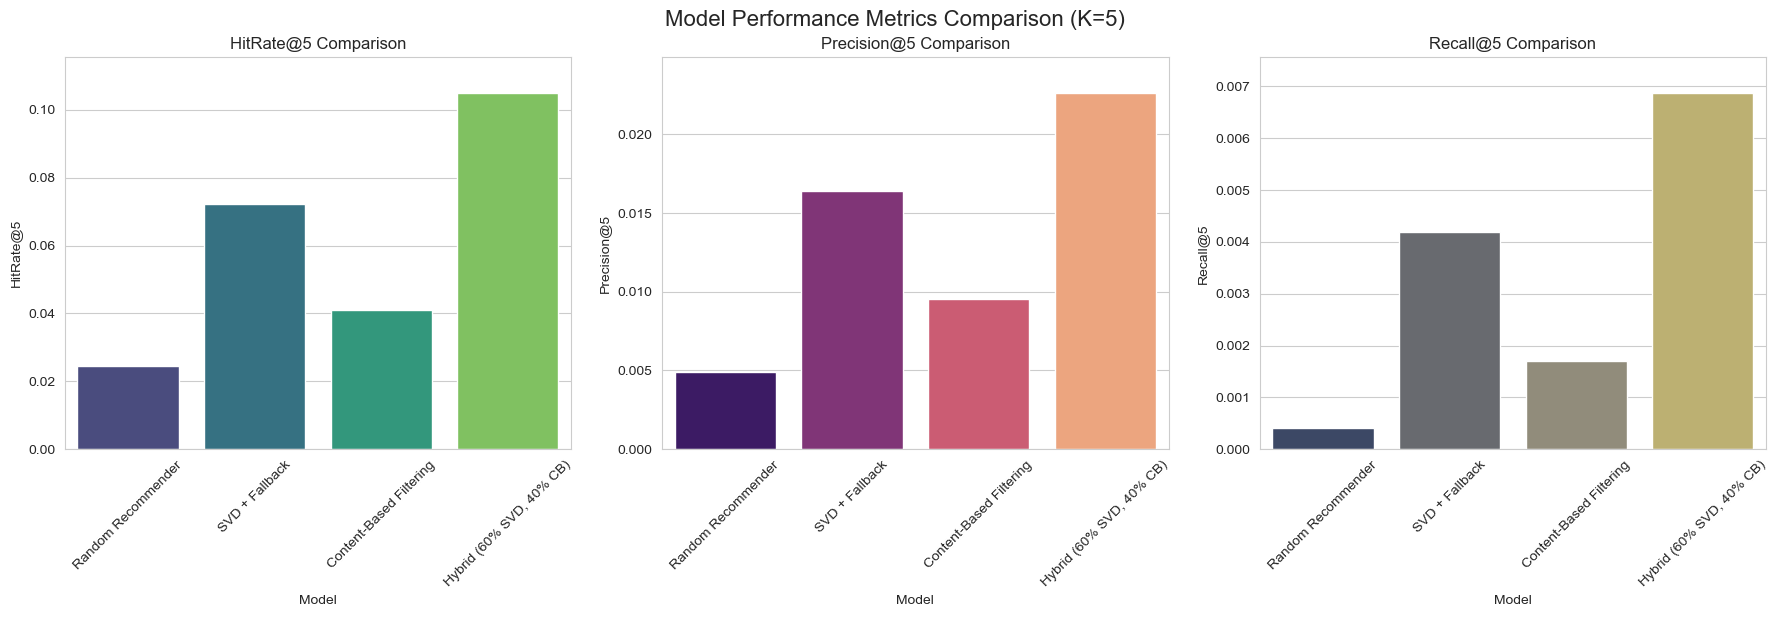


--- Model Performance Comparison Visualizations Complete ---


In [25]:
# Model Performance Comparison Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported if not already in this specific cell

# Re-create the comparison_df to ensure it has all the final calculated values
# This is a good practice for plotting at the end of the notebook.
comparison_data = {
    "Model": [
        "Random Recommender",
        "SVD + Fallback",
        "Content-Based Filtering",
        "Hybrid (60% SVD, 40% CB)"
    ],
    "HitRate@5": [random_hit_rate, svd_hit_rate, content_hit_rate, hybrid_hit_rate],
    "Precision@5": [random_precision, svd_precision, content_precision, hybrid_precision],
    "Recall@5": [random_recall, svd_recall, content_recall, hybrid_recall]
}
comparison_df_plot = pd.DataFrame(comparison_data)

# Set up the plot for multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False) # Changed sharey to False for potentially different scales between metrics

# Plot HitRate@5
sns.barplot(ax=axes[0], x='Model', y='HitRate@5', data=comparison_df_plot, palette='viridis')
axes[0].set_title('HitRate@5 Comparison')
axes[0].set_ylabel('HitRate@5')
axes[0].tick_params(axis='x', rotation=45) # Removed ha='right'
axes[0].set_ylim(0, comparison_df_plot['HitRate@5'].max() * 1.1) 

# Plot Precision@5
sns.barplot(ax=axes[1], x='Model', y='Precision@5', data=comparison_df_plot, palette='magma')
axes[1].set_title('Precision@5 Comparison')
axes[1].set_ylabel('Precision@5')
axes[1].tick_params(axis='x', rotation=45) # Removed ha='right'
axes[1].set_ylim(0, comparison_df_plot['Precision@5'].max() * 1.1)

# Plot Recall@5
sns.barplot(ax=axes[2], x='Model', y='Recall@5', data=comparison_df_plot, palette='cividis')
axes[2].set_title('Recall@5 Comparison')
axes[2].set_ylabel('Recall@5')
axes[2].tick_params(axis='x', rotation=45) # Removed ha='right'
axes[2].set_ylim(0, comparison_df_plot['Recall@5'].max() * 1.1)

plt.tight_layout()
plt.suptitle('Model Performance Metrics Comparison (K=5)', y=1.02, fontsize=16)
plt.show()

print("\n--- Model Performance Comparison Visualizations Complete ---")

In [26]:
# Top N Recommended Movies for a Sample User

import matplotlib.pyplot as plt
import pandas as pd

print("--- Starting Top N Recommendations Visualization for a Sample User ---")

# Choose a sample user ID from df_val
# Let's pick a user who has some validation data.
sample_user_id = df_val['userId'].sample(1, random_state=42).iloc[0]

print(f"\n--- Recommendations for User ID: {sample_user_id} ---")

# Get recommendations from each model for this user
# Note: top5_svd_recs, cb_top5, hybrid_top5 are dictionaries {user_id: [movie_ids]}
# We need to ensure these are available from prior cells.
if 'top5_svd_recs' not in locals():
    print("Warning: Model recommendation data not found. Please run all cells.")
    
model_recommendations = {
    "SVD + Fallback": top5_svd_recs.get(sample_user_id, []),
    "Content-Based Filtering": cb_top5.get(sample_user_id, []),
    "Hybrid (60% SVD, 40% CB)": hybrid_top5.get(sample_user_id, []),
    "Random Recommender": random_recs_dict.get(sample_user_id, []) # Assuming random_recs_dict is available
}

# Get actual watched movies for this user from df_val
actual_watched_movies = df_val[(df_val['userId'] == sample_user_id)]['movieId'].tolist()
actual_watched_titles = movies[movies['movieId'].isin(actual_watched_movies)]['title'].tolist()

print(f"\nUser {sample_user_id} Actually Watched (in validation set):")
for title in actual_watched_titles[:10]: # Limit to first 10 for readability
    print(f"- {title}")
if len(actual_watched_titles) > 10:
    print(f"- ...and {len(actual_watched_titles) - 10} more.")

print("\n--- Top 5 Recommended Movies by Each Model ---")
for model_name, rec_ids in model_recommendations.items():
    rec_titles = movies[movies['movieId'].isin(rec_ids)]['title'].tolist()
    
    # Highlight hits if they match actual watched movies
    hit_titles = [title for title in rec_titles if title in actual_watched_titles]
    
    print(f"\n{model_name}:")
    if rec_titles:
        for title in rec_titles:
            if title in hit_titles:
                print(f"- \033[1m{title} (HIT!)\033[0m") # Bold and color for hits
            else:
                print(f"- {title}")
    else:
        print("- No recommendations generated for this user.")

print("\n--- Top N Recommendations Visualization Complete ---")

--- Starting Top N Recommendations Visualization for a Sample User ---

--- Recommendations for User ID: 573 ---

User 573 Actually Watched (in validation set):
- Jumanji (1995)
- Usual Suspects, The (1995)
- Braveheart (1995)
- Apollo 13 (1995)
- Star Wars: Episode IV - A New Hope (1977)
- Batman (1989)
- Silence of the Lambs, The (1991)
- Twister (1996)
- Wallace & Gromit: A Close Shave (1995)
- Independence Day (a.k.a. ID4) (1996)
- ...and 50 more.

--- Top 5 Recommended Movies by Each Model ---

SVD + Fallback:
- Man Bites Dog (C'est arrivé près de chez vous) (1992)
- Outlaw Josey Wales, The (1976)
- Come and See (Idi i smotri) (1985)
- Jetée, La (1962)
- It's Such a Beautiful Day (2012)

Content-Based Filtering:
- Stunt Man, The (1980)
- Who Am I? (Wo shi shei) (1998)
- Hunting Party, The (2007)
- Machete (2010)
- Dragonheart 2: A New Beginning (2000)

Hybrid (60% SVD, 40% CB):
- Supercop 2 (Project S) (Chao ji ji hua) (1993)
- Boondock Saints, The (2000)
- Outlaw Josey Wales, The